In [21]:
# Analysis of Imbalance Ratio Effects on Loss Landscape and Overfitting

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional

In [22]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# Set TensorFlow deterministic operations
tf.config.experimental.enable_op_determinism()
# Set Python's random seed
import random
random.seed(42)
# Set environment variables for reproducibility
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'

In [23]:
class ImbalancedCircleDataset:
    """
    Generates a simple 2D regression dataset with imbalanced frequency bins.
    - Features: (x, y) coordinates
    - Target: Distance from origin (center)
    - Two bins: frequent (inner circle) and rare (outer circle)
    """
    
    def __init__(self, 
                 num_freq_samples: int = 10000,  # Number of samples in the frequent bin
                 imbalance_ratio: float = 10.0,  # Ratio of frequent to rare samples
                 radius_freq: float = 0.5,  # Radius for frequent samples
                 radius_rare: float = 0.8,  # Radius for rare samples
                 radius_width: float = 0.1  # Width of the radius band
                ):
        """
        Initialize the dataset generator.
        
        Args:
            num_freq_samples: Number of samples in the frequent bin
            imbalance_ratio: Ratio of frequent to rare samples
            radius_freq: Radius for frequent samples
            radius_rare: Radius for rare samples
            radius_width: Width of the radius band
        """
        self.num_freq_samples = num_freq_samples
        self.imbalance_ratio = imbalance_ratio
        self.radius_freq = radius_freq
        self.radius_rare = radius_rare
        self.radius_width = radius_width
        self._generate_base_dataset()
    
    def _generate_base_dataset(self) -> None:
        """
        Generate the base dataset with frequent and rare samples.
        This is called once during initialization to maintain consistency.
        """
        # Create the frequent samples (inner circle)
        num_freq = self.num_freq_samples
        theta_freq = np.linspace(0, 2*np.pi, num_freq, endpoint=False)
        
        # Add small jitter to radius but keep it within the band
        r_freq = self.radius_freq + np.random.uniform(
            0, self.radius_width, num_freq)
        
        x_freq = r_freq * np.cos(theta_freq)
        y_freq = r_freq * np.sin(theta_freq)
        
        # Create rare samples (outer circle) - same number as frequent initially
        num_potential_rare = self.num_freq_samples  # Same as frequent samples
        theta_rare = np.linspace(0, 2*np.pi, num_potential_rare, endpoint=False)
        
        r_rare = self.radius_rare + np.random.uniform(
            0, self.radius_width, num_potential_rare)
        
        x_rare = r_rare * np.cos(theta_rare)
        y_rare = r_rare * np.sin(theta_rare)
        
        # Store all potential samples
        self.x_freq, self.y_freq = x_freq, y_freq
        self.r_freq = r_freq
        self.x_rare_all, self.y_rare_all = x_rare, y_rare
        self.r_rare_all = r_rare
    
    def get_dataset(self, imbalance_ratio: Optional[float] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get dataset with specified imbalance ratio.
        
        Args:
            imbalance_ratio: Override the default imbalance ratio if provided
        
        Returns:
            Tuple of (features, targets) where features has shape (n_samples, 2)
            and targets has shape (n_samples,)
        """
        if imbalance_ratio is None:
            imbalance_ratio = self.imbalance_ratio
        
        # Calculate how many rare samples to include
        num_freq = len(self.x_freq)
        num_rare = int(num_freq / imbalance_ratio)
        num_rare = max(1, min(num_rare, len(self.x_rare_all)))  # Ensure valid range
        
        # Select rare samples (deterministically)
        indices = np.linspace(0, len(self.x_rare_all)-1, num_rare, dtype=int)
        x_rare = self.x_rare_all[indices]
        y_rare = self.y_rare_all[indices]
        r_rare = self.r_rare_all[indices]
        
        # Combine frequent and rare samples
        X = np.column_stack([
            np.concatenate([self.x_freq, x_rare]),
            np.concatenate([self.y_freq, y_rare])
        ])
        
        # Target is the distance from origin
        y = np.concatenate([self.r_freq, r_rare])
        
        # Create masks for visualization
        self.freq_mask = np.concatenate([np.ones(num_freq, dtype=bool), 
                                        np.zeros(num_rare, dtype=bool)])
        self.rare_mask = ~self.freq_mask
        
        return X, y
    
    def train_val_split(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        val_ratio: float = 0.2
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Split dataset into training and validation sets.
        Ensures both frequent and rare samples are represented in both sets.
        
        Args:
            X: Feature array of shape (n_samples, 2)
            y: Target array of shape (n_samples,)
            val_ratio: Fraction of data to use for validation
            
        Returns:
            X_train, X_val, y_train, y_val
        """
        # Split frequent samples
        num_freq = np.sum(self.freq_mask)
        num_freq_val = int(num_freq * val_ratio)
        freq_val_indices = np.linspace(0, num_freq-1, num_freq_val, dtype=int)
        freq_train_mask = np.ones(num_freq, dtype=bool)
        freq_train_mask[freq_val_indices] = False
        
        # Split rare samples
        num_rare = np.sum(self.rare_mask)
        num_rare_val = int(num_rare * val_ratio)
        rare_indices = np.where(self.rare_mask)[0] - num_freq  # Adjust index offset
        rare_val_indices = np.linspace(0, num_rare-1, num_rare_val, dtype=int)
        rare_val_indices = rare_indices[rare_val_indices]
        
        # Create combined masks
        train_mask = np.ones(len(X), dtype=bool)
        train_mask[freq_val_indices] = False
        train_mask[num_freq + rare_val_indices] = False
        val_mask = ~train_mask
        
        # Apply masks
        X_train, y_train = X[train_mask], y[train_mask]
        X_val, y_val = X[val_mask], y[val_mask]
        
        return X_train, X_val, y_train, y_val
    
    def plot_dataset(self, X: np.ndarray, y: np.ndarray, title: str = "Dataset Visualization") -> None:
        """
        Plot the dataset showing frequent and rare samples.
        
        Args:
            X: Feature array of shape (n_samples, 2)
            y: Target array of shape (n_samples,)
            title: Plot title
        """
        plt.figure(figsize=(10, 8))
        
        # Plot frequent samples
        plt.scatter(X[self.freq_mask, 0], X[self.freq_mask, 1], 
                   c=y[self.freq_mask], cmap='Blues', s=50, alpha=0.8,
                   label=f'Frequent ({np.sum(self.freq_mask)} samples)')
        
        # Plot rare samples
        plt.scatter(X[self.rare_mask, 0], X[self.rare_mask, 1], 
                   c=y[self.rare_mask], cmap='Reds', s=80, alpha=0.8, marker='x',
                   label=f'Rare ({np.sum(self.rare_mask)} samples)')
        
        plt.colorbar(label='Distance from center (target)')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.title(title)
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.axis('equal')
        plt.grid(alpha=0.3)
        plt.show()


In [24]:
def create_simple_model() -> tf.keras.Model:
    """
    Create a very simple neural network with only 2 parameters.
    
    Returns:
        A TensorFlow model with 2 trainable parameters
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(
            1, 
            use_bias=False, 
            activation=None, 
            kernel_initializer='zeros'
        )
    ])
    
    # Verify we have exactly 2 parameters (2 weights, no bias)
    assert len(model.trainable_variables) == 1
    assert model.trainable_variables[0].shape == (2, 1)  # weights
    assert model.trainable_variables[0].shape[0] * model.trainable_variables[0].shape[1] == 2  # total of 2 parameters
    
    return model



In [32]:
def train_model(
    model: tf.keras.Model, 
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    epochs: int = 200, 
    batch_size: int = 32,
    lr: float = 0.01
) -> Dict[str, List[float]]:
    """
    Train the model and track history.
    
    Args:
        model: TensorFlow model to train
        X_train, y_train: Training data
        X_val, y_val: Validation data
        epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate for the optimizer
        
    Returns:
        Dictionary with training history
    """
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    
    # Manual training to track parameters
    train_losses = []
    val_losses = []
    param_history = []
    
    # Convert to tensors
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
    
    # Training loop
    for epoch in range(epochs):
        # Shuffle training data
        indices = tf.random.shuffle(tf.range(len(X_train)))
        X_shuffled = tf.gather(X_train_tf, indices)
        y_shuffled = tf.gather(y_train_tf, indices)
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            with tf.GradientTape() as tape:
                y_pred = model(X_batch, training=True)
                loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_batch, -1)))
                
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Evaluate on full datasets
        y_train_pred = model(X_train_tf, training=False)
        train_loss = tf.reduce_mean(tf.square(y_train_pred - tf.expand_dims(y_train_tf, -1)))
        
        y_val_pred = model(X_val_tf, training=False)
        val_loss = tf.reduce_mean(tf.square(y_val_pred - tf.expand_dims(y_val_tf, -1)))
        
        # Save history
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        
        # Save parameter values
        w = model.trainable_variables[0].numpy().flatten()
        param_history.append(w)  # Just save the weights
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{epochs} - train_loss: {float(train_loss):.6f} - val_loss: {float(val_loss):.6f} - weights: [{w[0]:.4f}, {w[1]:.4f}]")
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'params': np.array(param_history)
    }
    
    return history


In [26]:
def compute_loss_landscape(
    model: tf.keras.Model, 
    X: np.ndarray, y: np.ndarray,
    w1_range: Tuple[float, float] = (-2, 2),
    w2_range: Tuple[float, float] = (-2, 2),
    resolution: int = 50
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the loss landscape by varying the two model weights.
    
    Args:
        model: TensorFlow model with 2 weights
        X, y: Dataset to compute loss on
        w1_range: Range for first weight parameter
        w2_range: Range for second weight parameter
        resolution: Grid resolution for the landscape
        
    Returns:
        Grid of parameter values and corresponding losses
    """
    # Create parameter grid
    w1_vals = np.linspace(w1_range[0], w1_range[1], resolution)
    w2_vals = np.linspace(w2_range[0], w2_range[1], resolution)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    
    # Original parameters
    original_w = model.trainable_variables[0].numpy().copy()
    
    # Convert data to tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # Compute loss for each parameter combination
    Z = np.zeros_like(W1)
    for i in range(resolution):
        for j in range(resolution):
            # Set model parameters
            w1 = W1[i, j]
            w2 = W2[i, j]
            model.trainable_variables[0].assign([[w1], [w2]])  # Set both weights
            
            # Compute loss
            y_pred = model(X_tf, training=False)
            loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_tf, -1)))
            Z[i, j] = loss.numpy()
    
    # Restore original parameters
    model.trainable_variables[0].assign(original_w)
    
    return W1, W2, Z

def plot_loss_landscape(
    W1: np.ndarray, 
    W2: np.ndarray, 
    Z: np.ndarray, 
    param_history: Optional[np.ndarray] = None,
    title: str = "Loss Landscape") -> None:
    """
    Plot the loss landscape with optional training trajectory.
    
    Args:
        W1, W2: Parameter grid for the two weights
        Z: Loss values at each point in the grid
        param_history: Optional trajectory of parameters during training
        title: Plot title
    """
    # Create a figure with 2 subplots (2D and 3D)
    fig = plt.figure(figsize=(10, 8))
    
    # 2D contour plot
    ax1 = fig.add_subplot(1, 2, 1)
    
    # Plot loss landscape as contour
    contour = ax1.contourf(W1, W2, Z, 50, cmap='viridis')
    plt.colorbar(contour, ax=ax1, label='Loss (MSE)')
    
    # Add contour lines
    contour_lines = ax1.contour(W1, W2, Z, 15, colors='white', alpha=0.5, linewidths=0.5)
    ax1.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    
    # Plot optimization trajectory if provided
    if param_history is not None:
        ax1.plot(param_history[:, 0], param_history[:, 1], 'r-', linewidth=2, alpha=0.7)
        ax1.scatter(param_history[0, 0], param_history[0, 1], c='blue', s=100, 
                  label='Start', zorder=10)
        ax1.scatter(param_history[-1, 0], param_history[-1, 1], c='red', s=100, 
                  label='End', zorder=10)
    
    ax1.set_title(f"2D {title}")
    ax1.set_xlabel('Weight 1 (w1)')
    ax1.set_ylabel('Weight 2 (w2)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 3D surface plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surface = ax2.plot_surface(W1, W2, Z, cmap='viridis', alpha=0.8, 
                              rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # Plot optimization trajectory in 3D if provided
    if param_history is not None:
        # Get Z values for the trajectory points by interpolating
        from scipy.interpolate import interpn
        points = (np.linspace(W1.min(), W1.max(), W1.shape[0]), 
                 np.linspace(W2.min(), W2.max(), W2.shape[0]))
        trajectory_z = interpn(points, Z, 
                              param_history[:, [0, 1]], 
                              method='linear', 
                              bounds_error=False, 
                              fill_value=None)
        
        ax2.plot(param_history[:, 0], param_history[:, 1], trajectory_z, 
                'r-', linewidth=2, alpha=0.7)
        ax2.scatter(param_history[0, 0], param_history[0, 1], trajectory_z[0], 
                   c='blue', s=100, zorder=10)
        ax2.scatter(param_history[-1, 0], param_history[-1, 1], trajectory_z[-1], 
                   c='red', s=100, zorder=10)
    
    ax2.set_title(f"3D {title}")
    ax2.set_xlabel('Weight 1 (w1)')
    ax2.set_ylabel('Weight 2 (w2)')
    ax2.set_zlabel('Loss (MSE)')
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(history: Dict[str, List[float]], title: str = "Training and Validation Loss") -> None:
    """
    Plot training and validation loss curves.
    
    Args:
        history: Training history dictionary
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.yscale('log')
    plt.show()


In [27]:
def analyze_imbalance_effects(
    imbalance_ratios: List[float], 
    num_freq_samples: int = 10000,
    radius_freq: float = 0.5,
    radius_rare: float = 0.8,
    radius_width: float = 0.1,
    epochs: int = 200
) -> Dict:
    """
    Analyze the effects of different imbalance ratios on model training.
    
    Args:
        imbalance_ratios: List of imbalance ratios to test
        num_freq_samples: Number of samples for the frequent class
        radius_freq: Radius of the frequent class circle
        radius_rare: Radius of the rare class circle
        radius_width: Width of the circles
        epochs: Number of training epochs
        
    Returns:
        Dictionary with analysis results
    """
    results = {
        'imbalance_ratios': imbalance_ratios,
        'final_train_loss': [],
        'final_val_loss': [],
        'min_train_loss': [],
        'min_val_loss': [],
        'overfit_degree': [],  # Difference between train and val loss
        'loss_landscapes': []
    }
    
    # Generate base dataset with default imbalance ratio (will be overridden)
    dataset = ImbalancedCircleDataset(
        num_freq_samples=num_freq_samples,
        radius_freq=radius_freq,
        radius_rare=radius_rare,
        radius_width=radius_width
    )
    
    total_ratios = len(imbalance_ratios)
    for i, ratio in enumerate(imbalance_ratios):
        print(f"Processing imbalance ratio {ratio}:1 ({i+1}/{total_ratios})")
        
        # Get dataset with current imbalance ratio
        X, y = dataset.get_dataset(imbalance_ratio=ratio)
        X_train, X_val, y_train, y_val = dataset.train_val_split(X, y)
        
        print(f"  Training model with {len(X_train)} training samples and {len(X_val)} validation samples")
        # Create and train model
        model = create_simple_model()
        history = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
        print(f"  Computing loss landscape for ratio {ratio}:1")
        # Compute loss landscape
        W, B, Z = compute_loss_landscape(model, X, y)
        
        # Store results
        results['final_train_loss'].append(history['train_loss'][-1])
        results['final_val_loss'].append(history['val_loss'][-1])
        results['min_train_loss'].append(min(history['train_loss']))
        results['min_val_loss'].append(min(history['val_loss']))
        results['overfit_degree'].append(history['val_loss'][-1] - history['train_loss'][-1])
        results['loss_landscapes'].append((W, B, Z, history))
        
        print(f"  Completed ratio {ratio}:1 - Final train loss: {history['train_loss'][-1]:.6f}, val loss: {history['val_loss'][-1]:.6f}")
    
    print(f"Analysis complete for all {total_ratios} imbalance ratios")
    return results



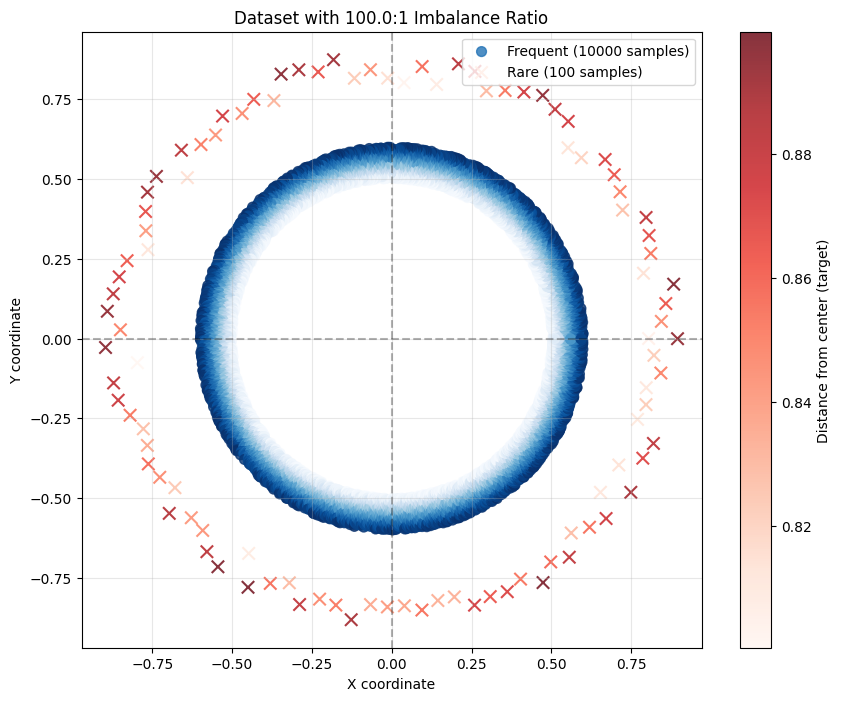

Epoch 1/20 - train_loss: 0.307853 - val_loss: 0.307442 - weights: [-0.0004, 0.0001]
Epoch 2/20 - train_loss: 0.307855 - val_loss: 0.307440 - weights: [0.0030, 0.0021]
Epoch 3/20 - train_loss: 0.307854 - val_loss: 0.307440 - weights: [0.0010, 0.0017]
Epoch 4/20 - train_loss: 0.307856 - val_loss: 0.307447 - weights: [0.0054, -0.0029]
Epoch 5/20 - train_loss: 0.307854 - val_loss: 0.307440 - weights: [0.0022, 0.0018]
Epoch 6/20 - train_loss: 0.307858 - val_loss: 0.307446 - weights: [-0.0042, 0.0006]
Epoch 7/20 - train_loss: 0.307856 - val_loss: 0.307450 - weights: [0.0002, -0.0051]
Epoch 8/20 - train_loss: 0.307853 - val_loss: 0.307444 - weights: [0.0022, -0.0023]
Epoch 9/20 - train_loss: 0.307861 - val_loss: 0.307441 - weights: [0.0006, 0.0064]
Epoch 10/20 - train_loss: 0.307854 - val_loss: 0.307440 - weights: [0.0016, 0.0016]
Epoch 11/20 - train_loss: 0.307857 - val_loss: 0.307442 - weights: [0.0055, 0.0017]
Epoch 12/20 - train_loss: 0.307859 - val_loss: 0.307440 - weights: [0.0027, 0.00

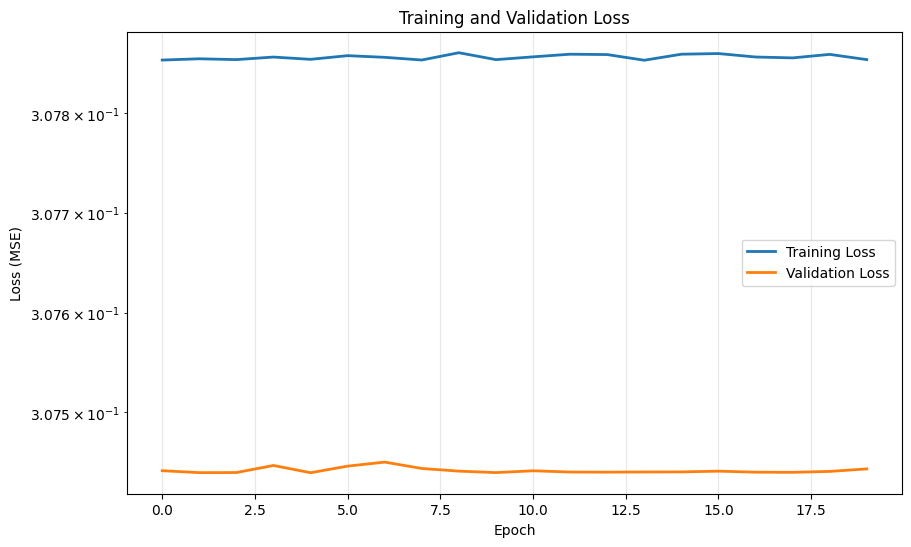

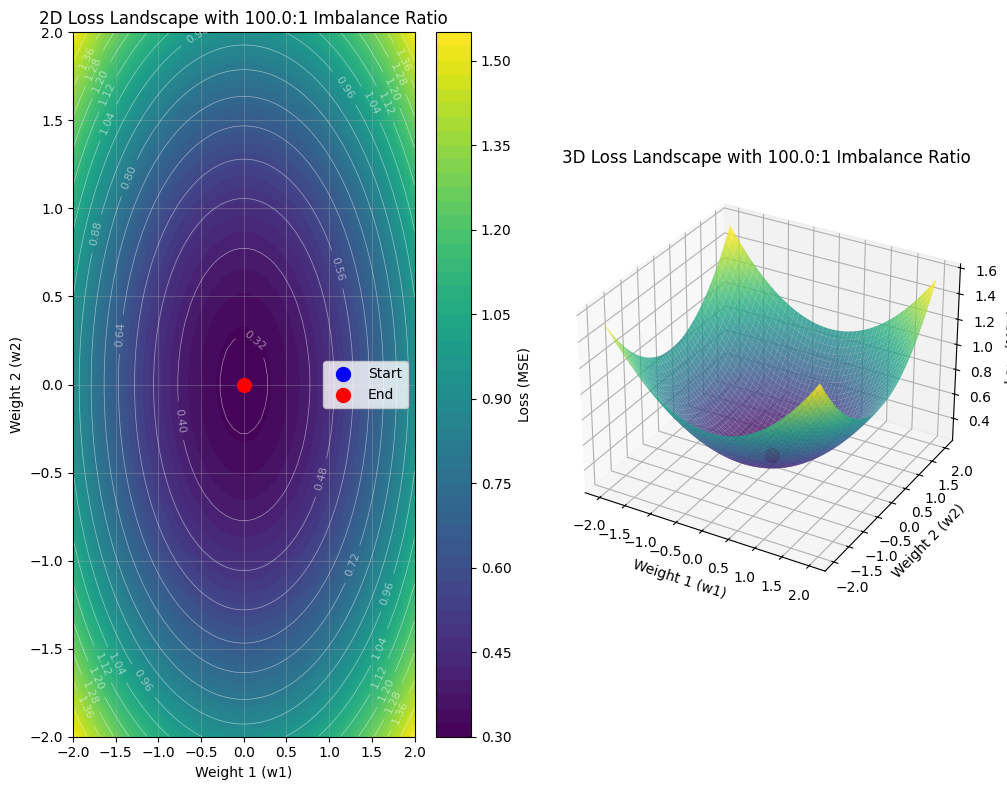

In [33]:
# Configuration
num_freq_samples = 10000
radius_freq = 0.5
radius_rare = 0.8
radius_width = 0.1

# Generate dataset
dataset = ImbalancedCircleDataset(
    num_freq_samples=num_freq_samples,
    radius_freq=radius_freq,
    radius_rare=radius_rare,
    radius_width=radius_width
)

imb_ratio = 1.0
lr = 1e-3

# Test with a single imbalance ratio
X, y = dataset.get_dataset(imbalance_ratio=imb_ratio)
dataset.plot_dataset(X, y, title=f"Dataset with {imb_ratio}:1 Imbalance Ratio")

# Train model
X_train, X_val, y_train, y_val = dataset.train_val_split(X, y)
model = create_simple_model()
history = train_model(model, X_train, y_train, X_val, y_val, lr=lr, epochs=20, batch_size=128)

# Plot results
plot_training_curves(history)

# Compute and plot loss landscape
W1, W2, Z = compute_loss_landscape(model, X, y)
plot_loss_landscape(W1, W2, Z, history['params'], title=f"Loss Landscape with {imb_ratio}:1 Imbalance Ratio")



In [ ]:


# Analyze multiple imbalance ratios
imbalance_ratios = [1.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0, 10000.0]
results = analyze_imbalance_effects(imbalance_ratios, config)

# Plot comparison of results
plt.figure(figsize=(12, 8))
plt.plot(imbalance_ratios, results['final_train_loss'], 'b-', label='Final Train Loss')
plt.plot(imbalance_ratios, results['final_val_loss'], 'r-', label='Final Val Loss')
plt.plot(imbalance_ratios, results['overfit_degree'], 'g-', label='Overfitting Degree')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Imbalance Ratio (log scale)')
plt.ylabel('Loss (MSE, log scale)')
plt.title('Effect of Imbalance Ratio on Model Performance')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

# Display selected loss landscapes
for i, ratio in enumerate([1.0, 100.0, 10000.0]):
    idx = imbalance_ratios.index(ratio)
    W, B, Z, hist = results['loss_landscapes'][idx]
    plot_loss_landscape(W, B, Z, hist['params'], 
                        title=f"Loss Landscape with {ratio}:1 Imbalance Ratio")
    plot_training_curves(hist, title=f"Training Curves with {ratio}:1 Imbalance Ratio")